# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [92]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from collections import defaultdict
from kmodes.kmodes import KModes
import re
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [93]:
# Load in the data, specifying datatypes for columns 18 and 19, which have mixtures of datatypes, to speed up import
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18: object, 19: object})
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18: object, 19: object})

# Create backup copies to avoid having to reimport
azdias_copy = azdias.copy()
customers_copy = customers.copy()

In [94]:
# Load in information on the features
feature_summary = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')

In [95]:
# Overview of customer data
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [96]:
# Overview of azdias data
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [105]:
# Overview of feature summary
feature_summary.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [98]:
# Find names of problematic 18th and 19th columns
customers.columns[18], customers.columns[19]
# According to the schema, these columns are the New German CAMEO Typology established together with Call Credit in late 2015

('CAMEO_DEUG_2015', 'CAMEO_INTL_2015')

In [99]:
# Change columns 18 and 19 to type float
customers['CAMEO_DEUG_2015'] = pd.to_numeric(customers['CAMEO_DEUG_2015'], errors='coerce')
customers['CAMEO_INTL_2015'] = pd.to_numeric(customers['CAMEO_INTL_2015'], errors='coerce')
azdias['CAMEO_DEUG_2015'] = pd.to_numeric(azdias['CAMEO_DEUG_2015'], errors='coerce')
azdias['CAMEO_INTL_2015'] = pd.to_numeric(azdias['CAMEO_INTL_2015'], errors='coerce')

In [100]:
# Explore dimensions of datasets
customers.shape, azdias.shape, feature_summary.shape

((191652, 369), (891221, 366), (85, 4))

I have detailed information about 85 columns thanks to the feature summary datafile. The customers and azdias datasets have 284 and 281 columns respectively. 
For similicity and to reduce processing power, I will cut these datasets down to just the columns for which I have detailed information

In [101]:
# Create list of columns for which I have detailed information
cols = list(feature_summary['attribute'])
cols.append('LNR')
# Add additional customer columns to the list
cust_cols = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
cust_cols = cols + cust_cols

In [102]:
# Cut down customer and azdias datasets to just columns found in feature_summary
customers = customers[cust_cols]
azdias = azdias[cols]

In [103]:
round(customers.isnull().sum(axis = 0)/customers.shape[0]*100,2).sort_values(ascending = False).head(10)

KK_KUNDENTYP    58.41
KBA05_ANTG3     29.21
KBA05_BAUMAX    29.21
KBA05_GBZ       29.21
KBA05_ANTG2     29.21
KBA05_ANTG1     29.21
MOBI_REGIO      29.21
KBA05_ANTG4     29.21
REGIOTYP        28.31
KKK             28.31
dtype: float64

In [106]:
# The feature_summary file contains some information on how missing fields are represented in different columns
feature_summary['missing_or_unknown'].value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,X]       1
[-1,XX]      1
[XX]         1
[-1,0,9]     1
Name: missing_or_unknown, dtype: int64

In [107]:
# Find columns with different missing value coing
neg_1_cols = feature_summary[feature_summary['missing_or_unknown'].str.contains('-1')]['attribute']
zero_cols = feature_summary[feature_summary['missing_or_unknown'].str.contains('0')]['attribute']
nine_cols = feature_summary[feature_summary['missing_or_unknown'].str.contains('9')]['attribute']
xx_cols = feature_summary[feature_summary['missing_or_unknown'].str.contains('XX')]['attribute']
x_cols = feature_summary[feature_summary['missing_or_unknown'].str.contains('X')]['attribute']

In [ ]:
# Replace -1 with NA for specified columns
customers[neg_1_cols] = customers.loc[:,neg_1_cols].replace({-1:np.nan})
azdias[neg_1_cols] = azdias.loc[:,neg_1_cols].replace({-1:np.nan})

In [ ]:
# Replace 0 with NA for specified columns
customers[zero_cols] = customers.loc[:,zero_cols].replace({0:np.nan})
azdias[zero_cols] = azdias.loc[:,zero_cols].replace({0:np.nan})

In [ ]:
# Replace 9 with NA for specified columns
customers[nine_cols] = customers.loc[:,nine_cols].replace({9:np.nan})
azdias[nine_cols] = azdias.loc[:,nine_cols].replace({9:np.nan})

In [ ]:
# Replace XX with NA for specified columns
customers[xx_cols] = customers.loc[:,xx_cols].replace({'XX':np.nan})
azdias[xx_cols] = azdias.loc[:,xx_cols].replace({'XX':np.nan})

In [ ]:
# Replace X with NA for specified columns
customers[x_cols] = customers.loc[:,x_cols].replace({'X':np.nan})
azdias[x_cols] = azdias.loc[:,x_cols].replace({'X':np.nan})

In [108]:
customers[neg_1_cols] = customers.loc[:,neg_1_cols].fillna(-1)

In [ ]:
kpdata[cat_cols] = kpdata[cat_cols].fillna('Missing')

In [ ]:
# Find and visualise columns with most missing data in customers dataset
round(customers.isnull().sum(axis = 0)/customers.shape[0]*100,2).sort_values(ascending = False).head(20).plot(kind = 'bar', figsize=(20,10))
plt.title(" % of missing values per column in customers dataset", fontdict={'fontsize': 16})
plt.ylabel('% of missing values', fontdict={'fontsize': 12})
plt.xlabel('columns in dataset', fontdict={'fontsize': 12})

In [ ]:
# Find columns with most missing data in azdias dataset
round(azdias.isnull().sum(axis = 0)/azdias.shape[0]*100,2).sort_values(ascending = False).head(20).plot(kind = 'bar', figsize=(20,10))
plt.title(" % of missing values per column in azdias dataset", fontdict={'fontsize': 16})
plt.ylabel('% of missing values', fontdict={'fontsize': 12})
plt.xlabel('columns in dataset', fontdict={'fontsize': 12})

In [ ]:
# Remove columns with a high proportion of missing data
# Columns which have >50% missing data in datasets
empty_cols_cust = list(customers.columns[customers.isnull().sum(axis = 0)/customers.shape[0]*100 > 50])
empty_cols_az = list(azdias.columns[azdias.isnull().sum(axis = 0)/azdias.shape[0]*100 > 50])

# Combine list of columns
empty_cols = set(empty_cols_cust + empty_cols_az)

# Remove columns from datasets
customers = customers.drop(columns = empty_cols, axis=1)
azdias = azdias.drop(columns = empty_cols, axis=1)
# Remove thes rows from feature_summary dataset
feature_summary = feature_summary.drop(feature_summary[feature_summary['attribute'].isin(empty_cols)].index, axis=0)

In [ ]:
# Remove rows with a high proportion of missing data (>80%)
empty_rows = customers[customers.isnull().sum(axis = 1)/customers.shape[1]*100 > 80].index
customers = customers.drop(empty_rows, axis=0)

empty_rows = azdias[azdias.isnull().sum(axis = 1)/azdias.shape[1]*100 > 80].index
azdias = azdias.drop(empty_rows, axis=0)

In [ ]:
# Explore datatypes so that I know the best imputation method to use
# There are 5 types of data in the dataset 
feature_summary['type'].value_counts()

In [ ]:
# 49 columns are ordinal
ordinal_cols = list(feature_summary[feature_summary['type'] == 'ordinal']['attribute'])
customers[ordinal_cols].head()

In [ ]:
# 18 columns are categorical
categorical_cols = list(feature_summary[feature_summary['type'] == 'categorical']['attribute'])
customers[categorical_cols].head()

In [ ]:
# 7 of the columns have numeric data types e.g Year of birth, number of cars, number of adults in household
numeric_cols = list(feature_summary[feature_summary['type'] == 'numeric']['attribute'])
customers[numeric_cols].head()

In [ ]:
# 6 columns have mixed data types e.g. lifestage (family, income etc)
mixed_cols = list(feature_summary[feature_summary['type'] == 'mixed']['attribute'])
customers[mixed_cols].head()

In [ ]:
# 1 column is type interval e.g. Interval of main age within household
interval_cols = list(feature_summary[feature_summary['type'] == 'interval']['attribute'])
customers[interval_cols].head()

In [ ]:
# Create function which fills missing values in columns within num_vars with the column mean
def fill_mean(df, num_vars):
    '''
    INPUT:
    df - dataframe with missing numeric values
    num_vars - object containing numeric columns in dataframe
    OUTPUT:
    df - dataframe with missing numeric values filled with column means
    
    Fills missing numeric values within a dataframe with column means.
    '''
    for col in num_vars:
            df[col] = df[col].fillna(df[col].mean(), axis = 0)
    return df

In [ ]:
# Fill numeric fields with mean
num_vars = list(feature_summary[feature_summary['type'] == 'numeric']['attribute'])

customers = fill_mean(customers, num_vars)
azdias = fill_mean(azdias, num_vars)

In [ ]:
# Create function which fills missing values with mode 
fill_mode = lambda col: col.fillna(col.mode()[0])
# Apply to all non-numerical columns in customers dataset
customers = customers.apply(fill_mode, axis=0)
# Apply to all non-numerical columns in azdias dataset
azdias = azdias.apply(fill_mode, axis=0)

One obervation is that column CAMEO_DEU_2015 appears to be a copy of CAMEO_DEUG_2015 with an additional letter field.

In [ ]:
# Extract letter from CAMEO_DEU_2015 into new column
customers['CAMEO_DEU_2015_let'] = customers['CAMEO_DEU_2015'].str[1]
azdias['CAMEO_DEU_2015_let'] = azdias['CAMEO_DEU_2015'].str[1]

In [ ]:
# Verify that remaining number from CAMEO_DEU_2015 is a duplicate of CAMEO_DEUG_2015
cameo_data = customers[['CAMEO_DEU_2015', 'CAMEO_DEUG_2015']]
cameo_data['CAMEO_DEU_2015_num'] = cameo_data['CAMEO_DEU_2015'].str[0]
cameo_data['CAMEO_DEU_2015_num'] = pd.to_numeric(cameo_data['CAMEO_DEU_2015_num'], errors='coerce')
cameo_data['diff'] = cameo_data['CAMEO_DEU_2015_num'] - cameo_data['CAMEO_DEUG_2015']
cameo_data['diff'].sum()

In [ ]:
# As the remaining number from CAMEO_DEU_2015 is a duplicate of CAMEO_DEUG_2015, remove original CAMEO_DEUG_2015 column
customers = customers.drop(columns = 'CAMEO_DEU_2015', axis=1)
azdias = azdias.drop(columns = 'CAMEO_DEU_2015', axis=1)
feature_summary = feature_summary.drop(feature_summary[feature_summary['attribute']== 'CAMEO_DEU_2015'].index, axis=0)

In [ ]:
# One hot encode categorical, non ordinal data
categorical_cols = list(feature_summary[(feature_summary['type'] == 'categorical')|(feature_summary['type'] == 'mixed')]['attribute'])
categorical_cols.append('CAMEO_DEU_2015_let')
customers_clean = pd.get_dummies(data=customers, columns=categorical_cols)   
azdias_clean = pd.get_dummies(data=azdias, columns=categorical_cols)

In [ ]:
# Check number of missing values in customers dataset
round(customers_clean.isnull().sum(axis = 0)/customers_clean.shape[0]*100,2).sort_values(ascending = False).head(10)

In [ ]:
# Check number of missing values in azdias dataset
round(azdias_clean.isnull().sum(axis = 0)/azdias_clean.shape[0]*100,2).sort_values(ascending = False).head(10)

In [131]:
# Create function which fills missing values in columns within num_vars with the column mean
def fill_mean(df, num_vars):
    '''
    INPUT:
    df - dataframe with missing numeric values
    num_vars - object containing numeric columns in dataframe
    OUTPUT:
    df - dataframe with missing numeric values filled with column means
    
    Fills missing numeric values within a dataframe with column means.
    '''
    for col in num_vars:
            df[col] = df[col].fillna(df[col].mean(), axis = 0)
    return df

# Create function which fills missing values with mode 
fill_mode = lambda col: col.fillna(col.mode()[0])

# Put cleaning steps in function
def clean_data(df, feature_summary):
    '''
     INPUT:
     df - dataframe of input data
     feature_summary - summary of data fields including data types and how missing values are represented
     OUTPUT:
     df_clean - dataframe of data ready for model
     
     Sorts columns with incorrect datatypes
     Removes columns which are not in features_summary df
     Replaces values which represent unknowns with NAs
     Removes columns and rows with a high proportion of unknown data
     Fills missing numeric values with mean
     Fills missing non-numeric values with mode
     Extract letter field from CAMEO_DEU_2015 and removes original column
     One hot encodes non-ordinal columns
     
     '''
    
    # Sort columns with incorrect datatypes
    for col in (['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']):
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    # Create list of columns for which I have detailed information
    cols = list(feature_summary['attribute'])
    # Add additional columns to the list
    add_cols = ['LNR', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'RESPONSE']
    all_cols = cols + add_cols
    df = df.loc[:,df.columns.isin(all_cols)]
    
    # Replace values which represent unknown values with na
    for value in [-1, 0, 9, 'XX', 'X']:
        cols = feature_summary[feature_summary['missing_or_unknown'].str.contains(str(value))]['attribute']
        df[cols] = df.loc[:,cols].replace({value:np.nan})
        #df[cols] = df.loc[:,cols].fillna(value)
    
    # Remove columns with a high proportion of missing data
    # Columns which have >50% missing data in datasets
    empty_cols = list(df.columns[df.isnull().sum(axis = 0)/df.shape[0]*100 > 50])
    # Remove columns from datasets
    df = df.drop(columns = empty_cols, axis=1)
    # Remove thes rows from feature_summary dataset
    feature_summary = feature_summary.drop(feature_summary[feature_summary['attribute'].isin(empty_cols)].index, axis=0)
    
    # Remove rows with a high proportion of missing data
    empty_rows = df[df.isnull().sum(axis = 1)/df.shape[1]*100 > 80].index
    df = df.drop(empty_rows, axis=0)
     
#     # Fill missing numeric fields with mean
    num_vars = list(feature_summary[feature_summary['type'] == 'numeric']['attribute'])
#     #df = fill_mean(df, num_vars)
    df = df.drop(num_vars, axis = 1)
    
    ## remove not cat data
#     num_vars = list(feature_summary[feature_summary['type'] == 'numeric']['attribute'])
#     df = df.drop(num_vars, axis = 1)
#     num_vars = list(feature_summary[feature_summary['type'] == 'ordinal']['attribute'])
#     df = df.drop(num_vars, axis = 1)
#     num_vars = list(feature_summary[feature_summary['type'] == 'interval']['attribute'])
#     df = df.drop(num_vars, axis = 1)
#     num_vars = list(feature_summary[feature_summary['type'] == 'mixed']['attribute'])
#     df = df.drop(num_vars, axis = 1)
    
    # Fill missing non-numeric fields with mode                                           
    #df = df.apply(fill_mode, axis=0)   
    df = df.fillna(-1)
        
    # Extract letter field from CAMEO_DEU_2015 and remove original, which is a duplicate of CAMEO_DEUG_2015
    df['CAMEO_DEU_2015_let'] = df['CAMEO_DEU_2015'].str[1]
    df_clean = df.drop(columns = 'CAMEO_DEU_2015', axis=1)
    feature_summary = feature_summary.drop(feature_summary[feature_summary['attribute']== 'CAMEO_DEU_2015'].index, axis=0)
    
    # One hot encode categorical, non ordinal data
    #categorical_cols = list(feature_summary[(feature_summary['type'] == 'categorical')|(feature_summary['type'] == 'mixed')]['attribute'])
    #categorical_cols.append('CAMEO_DEU_2015_let')
    #df_clean = pd.get_dummies(data=df, columns=categorical_cols)                                                                                                                                                         
    return df_clean

In [132]:
# # Check function is working
# Import data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18: object, 19: object})
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18: object, 19: object})
feature_summary = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')

In [133]:
# Apply function to datasets
customers_clean = clean_data(customers, feature_summary)
azdias_clean = clean_data(azdias, feature_summary)

/Users/pmacdonald/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [134]:
customers_clean.head()

,LNR,ALTER_HH,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_DEU_2015_let
0,9626,10.0,1.0,3.0,1.0,13.0,5.0,2.0,1.0,2.0,...,6.0,9.0,7.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,4.0,A
1,9628,11.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,2.0,...,-1.0,9.0,-1.0,3.0,FOOD,SINGLE_BUYER,0,1.0,4.0,NaN
2,143872,6.0,3.0,7.0,5.0,34.0,2.0,4.0,1.0,4.0,...,6.0,9.0,2.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,2.0,4.0,D
3,143873,8.0,1.0,7.0,4.0,24.0,2.0,1.0,2.0,2.0,...,-1.0,9.0,7.0,1.0,COSMETIC,MULTI_BUYER,0,1.0,4.0,C
4,143874,20.0,3.0,3.0,7.0,41.0,6.0,4.0,4.0,2.0,...,2.0,9.0,3.0,1.0,FOOD,MULTI_BUYER,0,1.0,3.0,B


In [140]:
customers_clean[['OST_WEST_KZ','CAMEO_DEU_2015_let']] = customers_clean[['OST_WEST_KZ','CAMEO_DEU_2015_let']].replace({-1:'Missing'})
azdias_clean[['OST_WEST_KZ', 'CAMEO_DEU_2015_let']] = azdias_clean[['OST_WEST_KZ', 'CAMEO_DEU_2015_let']].replace({-1:'Missing'})
#customers_clean['OST_WEST_KZ'] = customers_clean['OST_WEST_KZ'].replace({-1:np.'Missing'})
#azdias_clean['OST_WEST_KZ'] = azdias_clean['OST_WEST_KZ'].replace({-1:np.nan})
le = preprocessing.LabelEncoder()
customers_clean[['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'CAMEO_DEU_2015_let', 'OST_WEST_KZ']] = customers_clean[['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'CAMEO_DEU_2015_let', 'OST_WEST_KZ']].apply(le.fit_transform)
azdias_clean[['CAMEO_DEU_2015_let', 'OST_WEST_KZ']] = azdias_clean[['CAMEO_DEU_2015_let', 'OST_WEST_KZ']].apply(le.fit_transform)
#customers_clean[['CAMEO_DEU_2015_let', 'OST_WEST_KZ']] = customers_clean[['CAMEO_DEU_2015_let', 'OST_WEST_KZ']].apply(le.fit_transform)

In [141]:
customers_clean.head()

,LNR,ALTER_HH,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_DEU_2015_let
0,9626,10.0,1.0,3.0,1.0,13.0,5.0,2.0,1.0,2.0,...,6.0,9.0,7.0,3.0,1,0,0,1.0,4.0,0
1,9628,11.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,2.0,...,-1.0,9.0,-1.0,3.0,2,1,0,1.0,4.0,6
2,143872,6.0,3.0,7.0,5.0,34.0,2.0,4.0,1.0,4.0,...,6.0,9.0,2.0,3.0,1,0,0,2.0,4.0,3
3,143873,8.0,1.0,7.0,4.0,24.0,2.0,1.0,2.0,2.0,...,-1.0,9.0,7.0,1.0,0,0,0,1.0,4.0,2
4,143874,20.0,3.0,3.0,7.0,41.0,6.0,4.0,4.0,2.0,...,2.0,9.0,3.0,1.0,2,0,0,1.0,3.0,1


In [120]:
# customers_clean = customers_clean.fillna(-1)
# azdias_clean = azdias_clean.fillna(-1)

In [142]:
round(customers_clean.isnull().sum(axis = 0)/customers_clean.shape[0]*100,2).sort_values(ascending = False).head(10)

CAMEO_DEU_2015_let    0.0
KONSUMNAEHE           0.0
INNENSTADT            0.0
KBA05_ANTG1           0.0
KBA05_ANTG2           0.0
KBA05_ANTG3           0.0
KBA05_ANTG4           0.0
KBA05_GBZ             0.0
KKK                   0.0
LP_FAMILIE_FEIN       0.0
dtype: float64

In [143]:
round(azdias_clean.isnull().sum(axis = 0)/azdias_clean.shape[0]*100,2).sort_values(ascending = False).head(10)
# There are no longer any missing values in the datasets suggesting the function is working

CAMEO_DEU_2015_let    0.0
GREEN_AVANTGARDE      0.0
HH_EINKOMMEN_SCORE    0.0
INNENSTADT            0.0
KBA05_ANTG1           0.0
KBA05_ANTG2           0.0
KBA05_ANTG3           0.0
KBA05_ANTG4           0.0
KBA05_GBZ             0.0
KKK                   0.0
dtype: float64

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [144]:
# Remove columns which aren't present in both dataframes ahead of segmentation
uncommon_cols = set(customers_clean.columns).symmetric_difference(set(azdias_clean.columns))
customers_clean = customers_clean.drop(columns = uncommon_cols, axis=1, errors = 'ignore')
azdias_clean = azdias_clean.drop(columns = uncommon_cols, axis=1, errors = 'ignore')

In [145]:
customers_clean.shape

(191652, 75)

In [146]:
azdias_clean.shape
# Both datasets have the same number of rows and so are ready for segmenatation steps

(891221, 75)

In [147]:
# Remove ID column named LNR
customers_clean = customers_clean.drop(columns = ['LNR'], axis=1)
azdias_clean = azdias_clean.drop(columns = ['LNR'], axis=1)

### Standardise data

In [ ]:
# Look at distribution of a subset of columns based on code on https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c
customers_subset = customers_clean.iloc[: ,1:10]
sns.pairplot(customers_subset)

In [ ]:
# Even when looking at the first 10 columns many are not normally distributed
# Many clustering algorithms require features to be normally distributed therefore use apply scaler to standardize data

In [ ]:
x = customers_clean.apply(boxcox)
# x = azdias_clean.apply(boxcox)

In [ ]:
#https://stackoverflow.com/questions/48288363/pandas-apply-function-with-different-argument-values-to-different-columns
result_df = customers_clean.apply(lambda col: stats.boxcox(col, a.loc[col.name]))

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.power_transform.html
from sklearn.preprocessing import power_transform
data = [[1, 2], [3, 2], [4, 5]]
print(power_transform(data, method='box-cox'))


In [ ]:
# Declare and fit scaler to 
scaler = StandardScaler()
scaler.fit(customers_clean)
customers_scaled_features = scaler.transform(customers_clean)
customers_scaled = pd.DataFrame(customers_scaled_features, columns=customers_clean.columns)
customers_scaled.head()

# Apply scaler to customers dataset
azdias_scaled_features = scaler.transform(azdias_clean)
azdias_scaled = pd.DataFrame(azdias_scaled_features, columns=azdias_clean.columns)
azdias_scaled.head()

### Perform PCA

In [ ]:
# There are a lot of columns in the dataset and it is likely that a lot will correlate

In [ ]:
# There are a lot of columns in the dataset and it is likely that a lot will correlate
# Create visualisation of correlations between columns based on code on https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c
corr = customers_subset.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [ ]:
# Looking at the visualisation above, FINANZ_SPARER correlates strongly with FIANZ_ANLEGER and FIANZ_UNAUFFAELLIGER
# Therefore apply principle component analysis to reduce dimensionality of the datasets

In [ ]:
customers_clean.columns[customers_clean.dtypes == 'object']

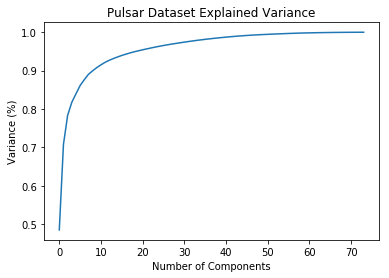

In [10]:
# customers_scaled changed to customers_clean
# Determine the number of components to use using link: https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
# Fitting the PCA algorithm with our Data
pca = PCA().fit(customers_clean)
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()
# Plot suggests 125 components descripe 90% of the data

In [11]:
# Customers scaled changed to customers_clean
# Apply PCA to azdias dataset
pca = PCA(n_components=20)
customers_components = pca.fit_transform(customers_clean)

# Apply to customers datast
azdias_components = pca.transform(azdias_clean)

### Apply Kmeans clustering algorithm

In [ ]:
#Determine number of clusters using elbow method - https://towardsdatascience.com/customer-segmentation-using-k-means-clustering-d33964f238c3
sse = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(customers_components)
    sse.append(kmeans.inertia_)
    
plt.figure(figsize=(12,6))    
plt.plot(range(1,10), sse)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Chart to establish the optimal number of clusters")
plt.show()
# 4 clusters looks optimal

In [148]:
km_cao = KModes(n_clusters=2, init = "Cao", verbose=1)
fitClusters_cao = km_cao.fit_predict(customers_clean)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 24437, cost: 6454058.0
Run 1, iteration: 2/100, moves: 605, cost: 6454058.0


In [149]:
km_huang = KModes(n_clusters=2, init = "Huang", verbose=1)
fitClusters_cao = km_huang.fit_predict(customers_clean)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 55476, cost: 6454036.0
Run 1, iteration: 2/100, moves: 478, cost: 6454036.0


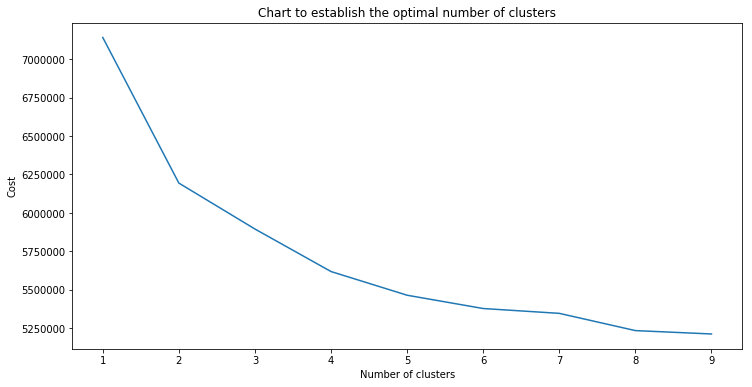

In [150]:
#Determine number of clusters using elbow method - https://towardsdatascience.com/customer-segmentation-using-k-means-clustering-d33964f238c3
cost = []
for k in range(1,10):
    kmodes = KModes(n_clusters=k, init = "Huang")
    kmodes.fit(customers_clean)
    cost.append(kmodes.cost_)
    
plt.figure(figsize=(12,6))    
plt.plot(range(1,10), sse)
plt.xlabel("Number of clusters")
plt.ylabel("Cost")
plt.title("Chart to establish the optimal number of clusters")
plt.show()
# 4 clusters looks optimal

In [ ]:
plt.figure(figsize=(12,6))    
plt.plot(range(1,30), sse)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Chart to establish the optimal number of clusters")
plt.show()
# 4 clusters looks optimal

In [152]:
# Apply kmeans to scaled data and create column of results
kmodes = KModes(n_clusters=4, random_state=20, verbose=1, init = "Huang")
#customers_components = pd.DataFrame(customers_components)
#azdias_components = pd.DataFrame(azdias_components)
customers_clean['clusters'] = kmodes.fit_predict(customers_clean)
azdias_clean['clusters'] = kmodes.predict(azdias_clean)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 68439, cost: 5932293.0
Run 1, iteration: 2/100, moves: 33538, cost: 5819797.0
Run 1, iteration: 3/100, moves: 15242, cost: 5790803.0
Run 1, iteration: 4/100, moves: 7985, cost: 5787293.0
Run 1, iteration: 5/100, moves: 310, cost: 5787293.0


In [41]:
#fig,(ax1,ax2) = plt.subplots(1,2, sharey = True)
#ax1.scatter(customers_clean[0][:,0],customers_clean[0][:,1], col = kmodes.labels_)
#plt.scatter(customers_clean[:,0],customers_clean[:,1], col = kmodes.labels_)

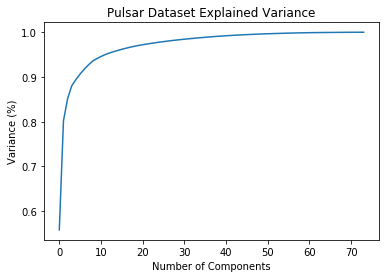

In [153]:
# customers_scaled changed to customers_clean
# Determine the number of components to use using link: https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
# Fitting the PCA algorithm with our Data
pca = PCA().fit(customers_clean.iloc[:,:-1])
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()
# Plot suggests 125 components descripe 90% of the data

In [154]:
# Customers scaled changed to customers_clean
# Apply PCA to azdias dataset
pca = PCA(n_components=20)
customers_components = pca.fit_transform(customers_clean.iloc[:,:-1])

# Apply to customers datast
azdias_components = pca.transform(azdias_clean.iloc[:,:-1])

In [46]:
customers_components

array([[ -2.32514447, -15.72585984,  -6.26949745, ...,   0.72920854,
         -0.66373741,  -0.17999614],
       [-16.26374592,   0.0550902 ,  -0.0917408 , ...,  -2.3357549 ,
         -1.94987319,   1.39332152],
       [ 18.14018527,  -7.25798015,   4.21960499, ...,   1.13898543,
         -0.70022477,   0.54581406],
       ...,
       [ -8.6477878 ,   9.29944896,  -7.19945997, ...,   0.73207766,
         -1.82689289,   1.20345458],
       [ -3.08579947,   3.24284035,  -0.23009611, ...,  -0.65874644,
          1.27608336,  -0.88891025],
       [ -1.99548923,  13.23533345,  -2.40078527, ...,  -1.59078653,
          1.44608962,  -0.06494948]])

In [155]:
tsne = TSNE(n_components=2, random_state=1986)
twodim_arr = tsne.fit_transform(customers_components)

In [18]:
# tsne = TSNE(n_components=2, random_state=1986)
# twodim_arr = tsne.fit_transform(customers_components.iloc[:,:-1])

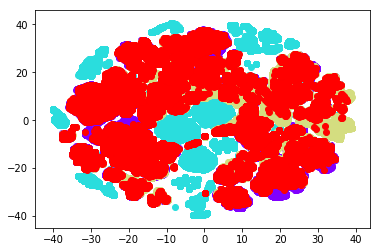

In [156]:
color = iter(plt.cm.rainbow(np.linspace(0,1,4)))

for group in list(customers_clean['clusters'].unique().tolist()):
    c = next(color)
    plt.scatter(twodim_arr[customers_clean['clusters'] == group, 0], 
                twodim_arr[customers_clean['clusters'] == group, 1],
                color=c,
                label=group)

In [163]:
np_customers_components=customers_clean.to_numpy()

AttributeError: 'DataFrame' object has no attribute 'to_numpy'

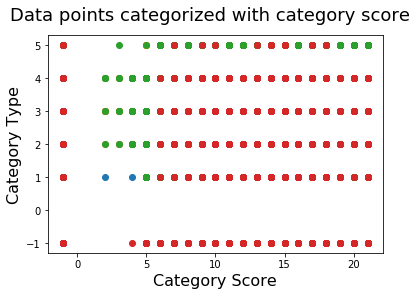

In [164]:
# Plot the results
for i in set(kmodes.labels_):
    index = kmodes.labels_ == i
    plt.plot(customers_clean.iloc[index, 0], customers_clean.iloc[index, 1], 'o')
    plt.suptitle('Data points categorized with category score', fontsize=18)
    plt.xlabel('Category Score', fontsize=16)
    plt.ylabel('Category Type', fontsize=16)
plt.show()

ValueError: x and y must be the same size

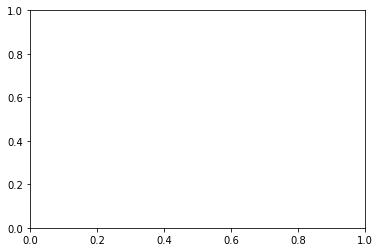

In [177]:
# Clustered result
fig1, ax3 = plt.subplots()
scatter = ax3.scatter(customers_clean, customers_clean['clusters'], c=customers_clean['clusters'], s=50)
ax3.set_xlabel('Data points')
ax3.set_ylabel('Cluster')
plt.colorbar(scatter)
ax3.set_title('Data points classifed according to known centers')
plt.show()
result = zip(customers_clean, kproto.labels_)
sortedR = sorted(result, key=lambda x: x[1])
print(sortedR)

In [157]:
tsne = TSNE(n_components=3, random_state=1986)
threedim_arr = tsne.fit_transform(customers_components)

KeyboardInterrupt: 

In [ ]:
color = iter(plt.cm.rainbow(np.linspace(0,1,4)))

for group in list(customers_clean['clusters'].unique().tolist()):
    c = next(color)
    plt.scatter(threedim_arr[customers_clean['clusters'] == group, 0], 
                threedim_arr[customers_clean['clusters'] == group, 1],
                color=c,
                label=group)

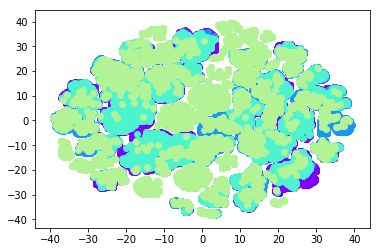

In [48]:
color = iter(plt.cm.rainbow(np.linspace(0,1,6)))

for group in list(customers_clean['clusters'].unique().tolist()):
    c = next(color)
    plt.scatter(twodim_arr[customers_clean['clusters'] == group, 0], 
                twodim_arr[customers_clean['clusters'] == group, 1],
                color=c,
                label=group)

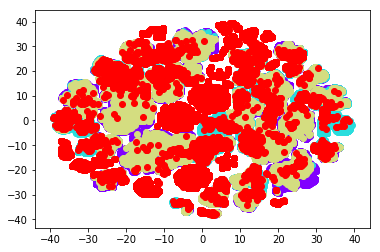

In [51]:
color = iter(plt.cm.rainbow(np.linspace(0,1,4)))

for group in list(customers_clean['clusters'].unique().tolist()):
    c = next(color)
    plt.scatter(twodim_arr[customers_clean['clusters'] == group, 0], 
                twodim_arr[customers_clean['clusters'] == group, 1],
                color=c,
                label=group)

In [52]:
# Attempt at 3D
tsne = TSNE(n_components=3, random_state=1986)
twodim_arr = tsne.fit_transform(customers_components)

# tsne = TSNE(n_components=3, random_state=1986)
# threedim_arr = tsne.fit_transform(customers_components.iloc[:,:-1])

# color = iter(plt.cm.rainbow(np.linspace(0,1,6)))

In [ ]:
color = iter(plt.cm.rainbow(np.linspace(0,1,6)))

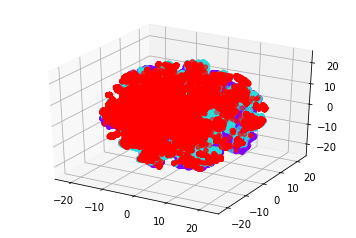

In [57]:
color = iter(plt.cm.rainbow(np.linspace(0,1,4)))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for group in list(customers_clean['clusters'].unique().tolist()):
    c = next(color)
    ax.scatter(twodim_arr[customers_clean['clusters'] == group, 1], 
               twodim_arr[customers_clean['clusters'] == group, 0],
               twodim_arr[customers_clean['clusters'] == group, 2],
               color=c,
               label=group)
    

In [58]:
pca = PCA(n_components=2)
pca_twodim_arr = pca.fit_transform(customers_clean.iloc[:,:-1])

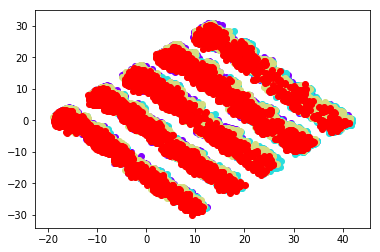

In [59]:
color = iter(plt.cm.rainbow(np.linspace(0,1,4)))

for group in list(customers_clean['clusters'].unique().tolist()):
    c = next(color)
    plt.scatter(pca_twodim_arr[customers_clean['clusters'] == group, 0], 
                pca_twodim_arr[customers_clean['clusters'] == group, 1],
                color=c,
                label=group)

In [61]:
pca = PCA(n_components=3)
pca_threedim_arr = pca.fit_transform(customers_clean.iloc[:,:-1])

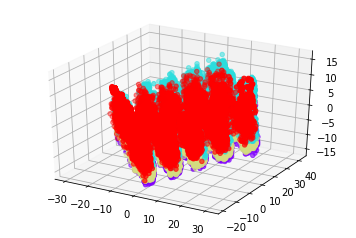

In [62]:
color = iter(plt.cm.rainbow(np.linspace(0,1,4)))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for group in list(customers_clean['clusters'].unique().tolist()):
    c = next(color)
    ax.scatter(pca_threedim_arr[customers_clean['clusters'] == group, 1], 
               pca_threedim_arr[customers_clean['clusters'] == group, 0],
               pca_threedim_arr[customers_clean['clusters'] == group, 2],
               color=c,
               label=group)

In [74]:
!pip uninstall seaborn

Found existing installation: seaborn 0.8.1
Uninstalling seaborn-0.8.1:
  Would remove:
    /Users/pmacdonald/anaconda3/lib/python3.7/site-packages/seaborn-0.8.1.dist-info/*
    /Users/pmacdonald/anaconda3/lib/python3.7/site-packages/seaborn/*
Proceed (y/n)? ^C
ERROR: Operation cancelled by user


In [75]:
!y

/bin/sh: y: command not found


In [76]:
!conda install -c conda-forge seaborn 

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::llvmlite==0.24.0=py37hc454e04_0
  - defaults/osx-64::qtawesome==0.4.4=py37_0
  - defaults/osx-64::terminado==0.8.1=py37_1
  - defaults/osx-64::appscript==1.0.1=py37h1de35cc_1
  - defaults/osx-64::locket==0.2.0=py37_1
  - defaults/osx-64::pycurl==7.43.0.2=py37hdbc3d79_0
  - defaults/osx-64::numpy==1.15.1=py37h6a91979_0
  - defaults/osx-64::snowballstemmer==1.2.1=py37_0
  - defaults/osx-64::pyqt==5.9.2=py37h655552a_2
  - defaults/osx-64::jdcal==1.4=py37_0
  - defaults/osx-64::dask==0.19.1=py37_0
  - defaults/osx-64::pygments==2.2.0=py37_0
  - defaults/osx-64::pkginfo==1.4.2=py37_1
  - defaults/osx-64::isort==4.3.4=py37_0
  - defaults/osx-64::jupyter==1.0.0=py37_7
  - defaults/osx-64::twisted==18.7.0=py37h1de35cc_1
  - defaults/osx-64::service_identity==17.0.0=py37h28b3542_0
  - defaults/osx-64::anaconda==5.3.0=py37_0


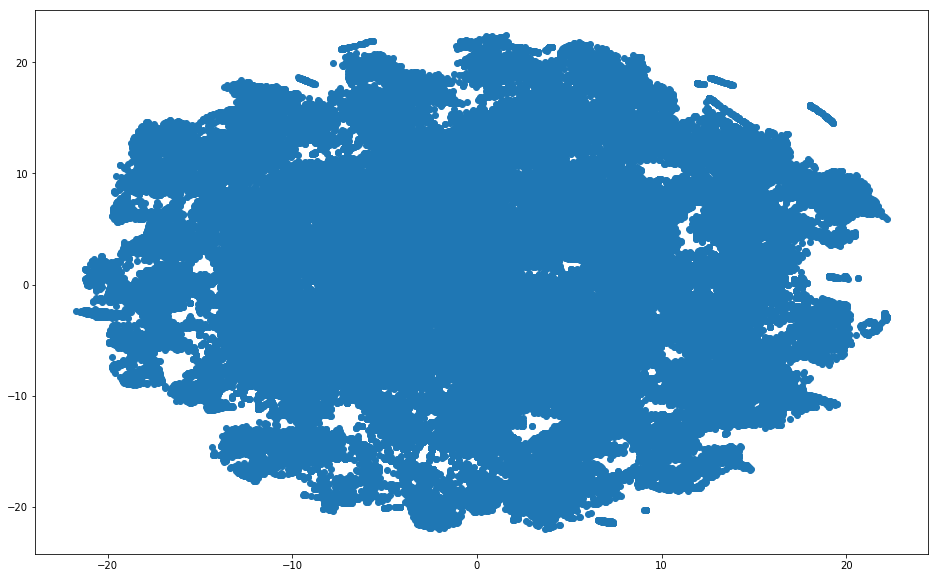

In [91]:
color = iter(plt.cm.rainbow(np.linspace(0,1,4)))

customers_clean['tsne-2d-one'] = twodim_arr[:,0]
customers_clean['tsne-2d-two'] = twodim_arr[:,1]
plt.figure(figsize=(16,10))
plt.scatter(
    x="tsne-2d-one", y="tsne-2d-two",
    cmap="clusters",
    #palette=sns.color_palette("hls", 10),
    data=customers_clean,
    #legend="full",
    #alpha=0.3
)

In [60]:
customers_clean.head()

,ALTER_HH,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,...,SOHO_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_DEU_2015_let,clusters
0,10.0,1.0,3.0,1.0,13.0,5.0,2.0,1.0,2.0,5.0,...,0.0,1.0,6.0,9.0,7.0,3.0,1.0,4.0,0,1
1,11.0,3.0,6.0,2.0,14.0,6.0,5.0,1.0,2.0,5.0,...,0.0,1.0,6.0,9.0,3.0,3.0,1.0,4.0,3,1
2,6.0,3.0,7.0,5.0,34.0,2.0,4.0,1.0,4.0,5.0,...,0.0,2.0,6.0,9.0,2.0,3.0,2.0,4.0,3,3
3,8.0,1.0,7.0,4.0,24.0,2.0,1.0,2.0,2.0,5.0,...,0.0,1.0,6.0,9.0,7.0,1.0,1.0,4.0,2,1
4,20.0,3.0,3.0,7.0,41.0,6.0,4.0,4.0,2.0,3.0,...,0.0,2.0,2.0,9.0,3.0,1.0,1.0,3.0,1,2


In [ ]:
# Apply kmeans to scaled data and create column of results
kmeans = KMeans(n_clusters=3, random_state=20)
customers_components = pd.DataFrame(customers_components)
azdias_components = pd.DataFrame(azdias_components)
customers_components['clusters'] = kmeans.fit_predict(customers_components)
azdias_components['clusters'] = kmeans.predict(azdias_components)

### Explore segments

In [ ]:
# Add clusters to scaled dataset
customers_scaled['clusters'] = customers_components['clusters']
azdias_scaled['clusters'] = azdias_components['clusters']

In [ ]:
# Calculate distribution of customer and genpop individuals across clusters
customer_perc = customers_scaled['clusters'].value_counts()/customers_scaled['clusters'].shape[0]*100
gen_pop_perc = azdias_scaled['clusters'].value_counts()/azdias_scaled['clusters'].shape[0]*100
distributions = {'Customers': customer_perc, 'Genpop': gen_pop_perc}
dists = pd.DataFrame(data=distributions)

# Visualise distributions
dists.plot(kind = 'bar', figsize=(20,10))
plt.ylabel("Percentage of population", fontdict={'fontsize': 12})
plt.xlabel("Cluster number", fontdict={'fontsize': 12})
plt.title("Distribution of customer and general population data across clusters", fontdict={'fontsize': 16})

Customers are more likely to be in cluster 2 and less likely to be in cluster 0 than the general population.

In [ ]:
# Find average score for clusters 1
cust_avg = customers_scaled[customers_scaled['clusters'].isin([1])].mean()
genpop_avg = azdias_scaled[azdias_scaled['clusters'].isin([1])].mean()

In [ ]:
# Calcuate difference between customer score and gen pop score
customer_scores = pd.concat([cust_avg, genpop_avg], axis=1).rename(columns={0: "customers", 1: "genpop"})
customer_scores['diff'] = customer_scores['customers'] - customer_scores['genpop']
customer_scores['abs_diff'] = abs(customer_scores['customers'] - customer_scores['genpop'])
customer_scores.sort_values(by = 'abs_diff',ascending = False)['diff'].head(20).plot(kind = 'bar')
plt.ylabel("Difference in average score", fontdict={'fontsize': 12})
plt.xlabel("Features", fontdict={'fontsize': 12})
plt.title("Chart to demonstrate the features which differ most between Customer and General Population", fontdict={'fontsize': 16})

From the analysis above, customers are less likely than the general population to:

- Be Single low-income earners of younger age - 'LP_LEBENSPHASE_FEIN_1.0'
- Be 90ies - digital media kids (Mainstream, O+W) - 'PRAEGENDE_JUGENDJAHRE_14.0' 
- Be from poorer Households-Pre-Family Couples & Singles - 'CAMEO_INTL_2015_51.0'
- Be from working class - 'CAMEO_DEUG_2015_8.0'
- Be Single low-income- and average earners of higher age - 'LP_LEBENSPHASE_GROB_2.0'
- Be 'shopping-stressed' shopping type - 'SHOPPER_TYP_1.0
- Be single - 'LP_FAMILIE_GROB_1.0'
- Be insurance typology: individualistic-accepting risks - 'VERS_TYP_2.0'

From the above analysis, customers are more likely than the general population to:

- To have low mobility - 'MOBI_REGIO'
- Have Number of 1-2 family houses in the cell- 'KBA05_ANTG1'
- Have a higher average age within household - 'ALTER_HH'
- Be 50ies - milk bar / Individualisation (Avantgarde, O+W) - 'PRAEGENDE_JUGENDJAHRE_4.0'
- Be Insurance typology: social-safety driven - 'VERS_TYP_1.0'
- Be in group Wealthy Households-Older Families &  Mature Couples - 'CAMEO_INTL_2015_14.0'
- Be upper middleclass - 'CAMEO_DEUG_2015_2.0'
- Be demanding shopper shopping type - 'SHOPPER_TYP_3.0'
- Be 'CAMEO_DEU_2015_let_B' or 'CAMEO_DEU_2015_let_D' - difficult to interpret
- Be top earners at retirement age from mulitperson households - 'LP_LEBENSPHASE_FEIN_40.0'
- Be single homeowners at retirement age - 'LP_LEBENSPHASE_GROB_12.0'

In conclusion, Arvato customers are generally older, perhaps retired, top earners and of an upper class.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
# Load training data
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
feature_summary = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')

In [ ]:
# Visualise data
mailout_train.head()

In [ ]:
# Apply cleaning function to cleaning data
train = clean_data(mailout_train, feature_summary)

In [ ]:
# Visualise clean training data
train.head()

In [ ]:
train.dtypes.value_counts()

In [ ]:
# Define a function to fit model from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['RESPONSE'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['RESPONSE'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['RESPONSE'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', figsize=(20,10))
    plt.ylabel('Feature Importance Score', fontdict={'fontsize': 12})
    plt.xlabel("Features", fontdict={'fontsize': 12})
    plt.title("Feature Importance", fontdict={'fontsize': 16})

In [ ]:
# Define target variable and ID column
target = 'RESPONSE'
IDcol = 'LNR'

In [ ]:
# Define starting parameters and apply function
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1, # ~Learning rate. Low value chosen to reduce computer processing
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1, # Low value due to imbalance in dataset
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

In [ ]:
# Tune max_depth and min_child_weight as these should have greatest impact
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
# Tune max_depth and min_child_weight further
# Pick values one up and one down from optimal values found in previous step
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
# Tune gamma (using established parameters above)
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
# Re fit with optimised parameters
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [ ]:
# Tune subsample and colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
# Adjust subsample and colsample_bytree ±0.05 around optimal values
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

In [ ]:
# Adjust regularisation parameters to reduce overfitting
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
# Try values close to optimum
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
# Put it all together
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

In [ ]:
# Finally reduce learning rate and add more trees
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

In [ ]:
# Assign target variable to Y
# Assign all columns minus target variable to X
Y = mailout_train_clean['RESPONSE']
X = mailout_train_clean.drop(columns = ['RESPONSE'], axis = 1)

In [ ]:
# Split into training and validation datasets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size =0.3, random_state=101)

In [ ]:
# Convert training data to a DMatrix for XGBoost model
trainDMat = xgb.DMatrix(data=X_train,
                        label=Y_train)

In [ ]:
# Define parameters
xgb_params = {'objective': 'binary:logistic',
              'eta': 0.3, # ~Learning rate. Low value chosen to reduce computer processing
              'max_depth': 4,  
              'min_child_weight': 1, # Low value due to imbalance in dataset
              'subsample': 0.8,
              'gamma': 0.1,
              'colsample_bytree': 0.8}

In [ ]:
# Train the XGBoost model
xgb_model = xgb.train(params=xgb_params,
                      dtrain=trainDMat)

In [ ]:
# Convert validation data to a DMatrix for XGBoost model
valDMat = xgb.DMatrix(data=X_val)

In [ ]:
# Use xgb model to predict on validation data
preds = xgb_model.predict(valDMat)

In [ ]:
# Evaluate AUC scores
roc_auc_score(Y_val, preds)

In [ ]:
# Evaluate ROC curve - https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
false_pos, true_pos, _ = roc_curve(Y_val, preds)
# plot the roc curve for the model
pyplot.plot(false_pos, true_pos)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the plot
pyplot.show()

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# Import test data
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
feature_summary = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')

In [ ]:
# Apply cleaning function
test = clean_data(mailout_test, feature_summary)

In [ ]:
test.head()

In [ ]:
# Define target variable and ID column
target = 'RESPONSE'
IDcol = 'LNR'
predictors = [x for x in test.columns if x not in [target, IDcol]]
predictors = test[predictors]

In [ ]:
test['RESPONSE'] = xgb1.predict(predictors)

In [ ]:
kaggle_data = test[['LNR', 'RESPONSE']]

In [ ]:
kaggle_data.head()

In [ ]:
kaggle_data.to_csv('data/kaggle_submission_3.csv', index=False)